David Rodriguez Gerrard

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

<h3>1 - Importar datos</h3>

In [2]:
file_path = "winequality-red.csv"
df = pd.read_csv(file_path, sep=";")

<h3>2 - Tratamiento y Matriz de correlación</h3>

In [3]:
df['quality_category'] = pd.cut(df['quality'], bins=[2, 4, 6, 8], labels=["Baja", "Media", "Alta"])
df.drop(columns=['quality'], inplace=True)

In [5]:
df['quality_category'] = df['quality_category'].astype(str)

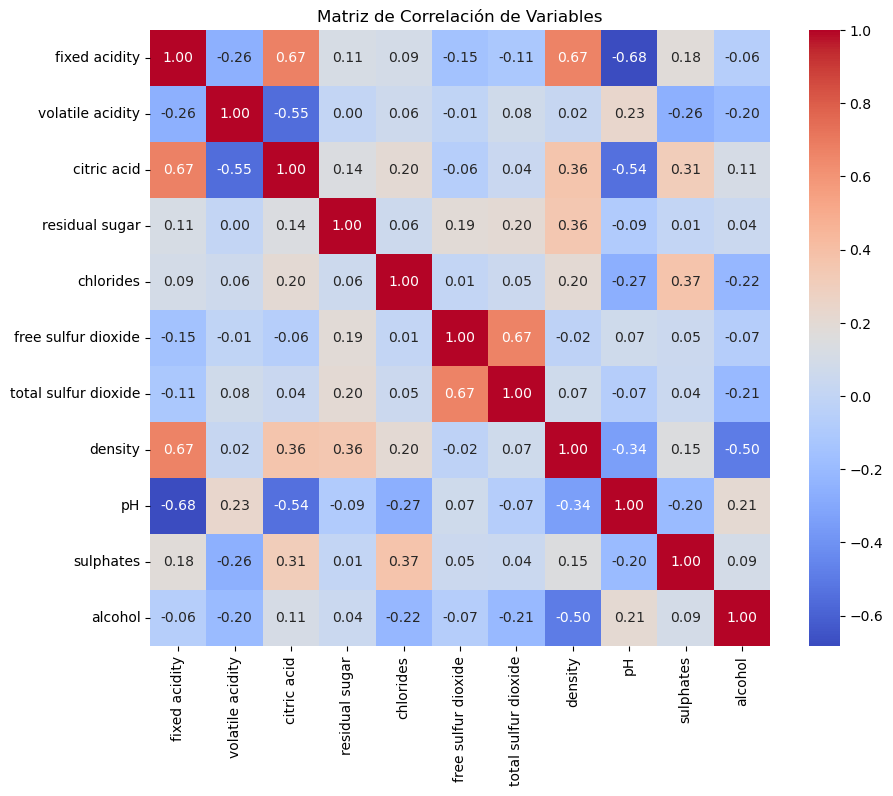

In [7]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación de Variables")
plt.show()

<h3>3 - SelectKBest</h3>

In [16]:
X = df.drop(columns=['quality_category'])
y = df['quality_category']

selector = SelectKBest(score_func=f_classif, k=8)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
not_selected_features = X.columns[~selector.get_support()]
print("Características seleccionadas:", selected_features)
print("Características no seleccionadas:", not_selected_features.tolist())

Características seleccionadas: Index(['fixed acidity', 'volatile acidity', 'citric acid',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')
Características no seleccionadas: ['residual sugar', 'chlorides', 'free sulfur dioxide']


<h3>4 - Comparar modelos: NaiveBayes Gaussian vs KNN Neighbors Classifier</h3>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
models = {
    "Naive Bayes": GaussianNB(),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

In [11]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Precisión media: {scores.mean():.4f}")

Naive Bayes - Precisión media: 0.7983
KNN (k=5) - Precisión media: 0.8249


<h3>Matriz de confusión del mejor modelo: KNN</h3>

In [12]:
best_model = KNeighborsClassifier(n_neighbors=5)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

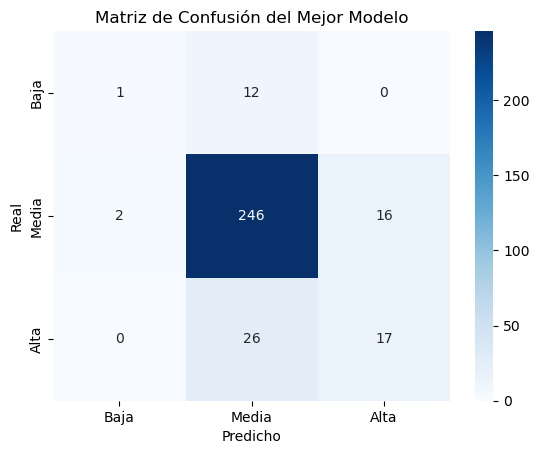

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=["Baja", "Media", "Alta"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja", "Media", "Alta"], yticklabels=["Baja", "Media", "Alta"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión del Mejor Modelo")
plt.show()

In [14]:
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

Reporte de Clasificación:
               precision    recall  f1-score   support

        Alta       0.52      0.40      0.45        43
        Baja       0.33      0.08      0.12        13
       Media       0.87      0.93      0.90       264

    accuracy                           0.82       320
   macro avg       0.57      0.47      0.49       320
weighted avg       0.80      0.82      0.81       320



<h3>Guardar y cargar parámetros para seguir entrenando sin tener que empezar de 0</h3>

In [18]:
joblib.dump({
    "model": best_model,
    "scaler": scaler,
    "selected_features": selected_features.tolist()
}, "parametros_guardados.pkl")

['parametros_guardados.pkl']

In [19]:
loaded_params = joblib.load("parametros_guardados.pkl")
loaded_model = loaded_params["model"]
loaded_scaler = loaded_params["scaler"]
loaded_features = loaded_params["selected_features"]
print("Modelo y parámetros cargados correctamente.")

Modelo y parámetros cargados correctamente.


<h3>Entrenar todo el dataset</h3>

In [27]:
df_selected = numeric_df[selected_features]  # Mantener solo las características seleccionadas
df_scaled = loaded_scaler.transform(df_selected)  # Aplicar el escalador
y_full_pred = loaded_model.predict(df_scaled)

c:\Users\davidrg\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


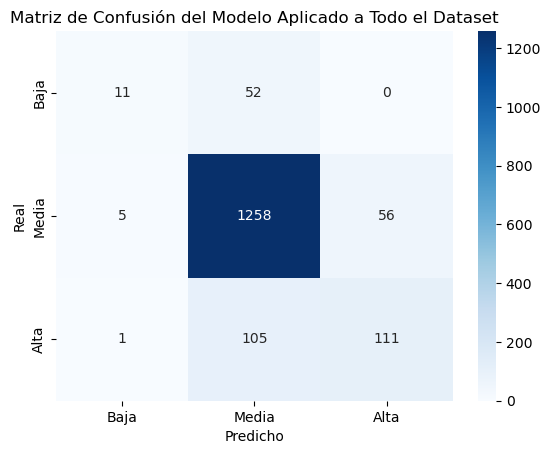

In [28]:
y_true = df['quality_category']
cm_full = confusion_matrix(y_true, y_full_pred, labels=["Baja", "Media", "Alta"])
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja", "Media", "Alta"], yticklabels=["Baja", "Media", "Alta"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión del Modelo Aplicado a Todo el Dataset")
plt.show()

In [29]:
print("Reporte de Clasificación en todo el dataset:\n", classification_report(y_true, y_full_pred))

Reporte de Clasificación en todo el dataset:
               precision    recall  f1-score   support

        Alta       0.66      0.51      0.58       217
        Baja       0.65      0.17      0.28        63
       Media       0.89      0.95      0.92      1319

    accuracy                           0.86      1599
   macro avg       0.73      0.55      0.59      1599
weighted avg       0.85      0.86      0.85      1599



<h3>Vinos Blancos</h3>

In [34]:
file_path_white = "winequality-white.csv"
df_white = pd.read_csv(file_path_white, sep=";")

In [35]:
df_white['quality_category'] = pd.cut(df_white['quality'], bins=[2, 4, 6, 8], labels=["Baja", "Media", "Alta"])
df_white.drop(columns=['quality'], inplace=True)
df_white['quality_category'] = df_white['quality_category'].astype(str)

In [36]:
df_white = df_white.dropna()

In [37]:
numeric_df_white = df_white.select_dtypes(include=[np.number])
df_white_selected = numeric_df_white[selected_features]
df_white_scaled = scaler.transform(df_white_selected)

c:\Users\davidrg\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [38]:
y_white_true = df_white['quality_category']
y_white_pred = best_model.predict(df_white_scaled)

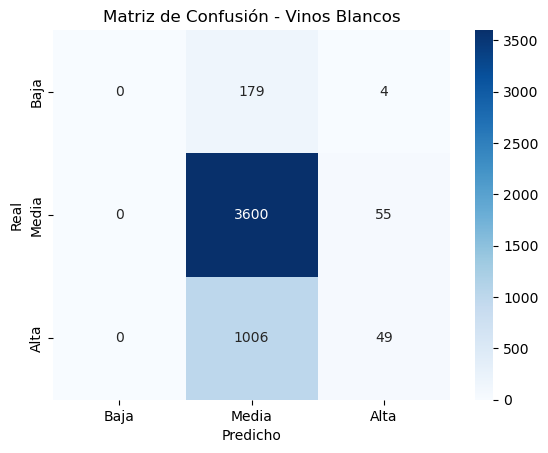

Reporte de Clasificación - Vinos Blancos:
               precision    recall  f1-score   support

        Alta       0.45      0.05      0.08      1055
        Baja       0.00      0.00      0.00       183
       Media       0.75      0.98      0.85      3655
         nan       0.00      0.00      0.00         5

    accuracy                           0.74      4898
   macro avg       0.30      0.26      0.23      4898
weighted avg       0.66      0.74      0.65      4898



c:\Users\davidrg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\davidrg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\davidrg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
cm_white = confusion_matrix(y_white_true, y_white_pred, labels=["Baja", "Media", "Alta"])
sns.heatmap(cm_white, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja", "Media", "Alta"], yticklabels=["Baja", "Media", "Alta"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Vinos Blancos")
plt.show()

print("Reporte de Clasificación - Vinos Blancos:\n", classification_report(y_white_true, y_white_pred))